# Stroke Prediction Dataset

Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

---

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

## Leitura dos Dados

In [2]:
df = pd.read_csv('../data/raw/healthcare-dataset-stroke-data.csv')

## Tratamento dos Dados

Uma das boas práticas de programação é fazer uma cópia do dataframe antes de realizar qualquer alteração.

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


* gender = Other

In [4]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Como só tem 1 registro onde gender = Other e como stroke = 0 para esse registro, então é melhor excluir o registro.

In [5]:
df = df.loc[df['gender'] != 'Other']

In [6]:
df.shape

(5109, 12)

* Coluna ID

A coluna 'id' é uma coluna de valores únicos e não é interessante pro modelo. Sendo assim, essa coluna pode ser dropada.

In [7]:
df.drop(columns='id', axis=1, inplace=True)

Para facilitar, vamos trocar os valores das colunas binárias por números, para facilitar para o modelo:

In [8]:
mapping = {
    'Yes': 1,
    'No': 0,
    'Urban': 1,
    'Rural': 0
}

In [9]:
cols_to_replace = ['ever_married', 'Residence_type']
df[cols_to_replace] = df[cols_to_replace].replace(mapping)

/var/folders/kx/v27q2wv94wn1gwc612y842400000gp/T/ipykernel_15191/3987150964.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[cols_to_replace] = df[cols_to_replace].replace(mapping)


In [10]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1


#### Tratamento dos dados nulos

Há dois tratamentos possíveis para os dados faltantes:
* Excluir os registros com dados faltantes
* Preencher os dados faltantes com o valor da mediana


Para a exclusão dos registros com dados faltantes:

Vantagens:
- Sem distorção de dados
- Sem viés introduzido
- Dados 100% confiáveis
- Simples e honesto

Desvantagens:
- Perde 201 registros (3.93%)
- Reduz poder estatístico


Para o preenchimento dos dados faltantes com a mediana:

Vantagens:
- Mantém todos os 5109 registros (excluindo gender == Other)
- Usa a mediana (robusta a outliers)
- Seu Q2 = 28.1 é a escolha ideal
- Não distorce a distribuição tanto quanto a média

Desvantagens:
- Reduz artificialmente a variância
- Cria múltiplos valores iguais
- Pode mascarar padrões reais

In [11]:
df_null = df.copy()

In [12]:
(df_null.bmi.isnull()\
        .value_counts(normalize=True)*100)\
        .round(2)\
        .astype(str) + "%"

bmi
False    96.07%
True      3.93%
Name: proportion, dtype: object

In [13]:
df_null['bmi'].isna().sum()

np.int64(201)

<Axes: xlabel='bmi'>

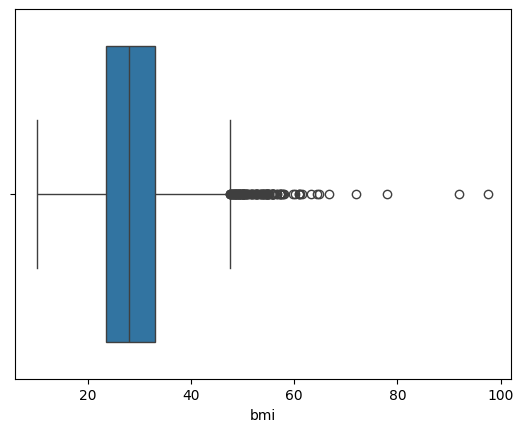

In [14]:
sns.boxplot(df_null, x='bmi')

Métricas Estatísticas

In [15]:
Q1 = df_null['bmi'].quantile(.25)
Q2 = df_null['bmi'].quantile(.5)
Q3 = df_null['bmi'].quantile(.75)
IQR = Q3 - Q1
lim_inf =  Q1 - 1.5 * IQR
lim_sup =  Q3 + 1.5 * IQR

In [16]:
outliers_index = (df_null['bmi'] < lim_inf) | (df_null['bmi'] > lim_sup)
df_null[outliers_index]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
21,Female,52.0,1,0,1,Self-employed,1,233.29,48.9,never smoked,1
113,Female,45.0,0,0,1,Private,0,224.10,56.6,never smoked,1
254,Female,47.0,0,0,1,Private,1,210.95,50.1,Unknown,0
258,Female,74.0,1,0,1,Self-employed,1,205.84,54.6,never smoked,0
270,Female,57.0,1,0,1,Private,0,129.54,60.9,smokes,0
...,...,...,...,...,...,...,...,...,...,...,...
4858,Female,43.0,0,0,1,Private,1,100.88,47.6,smokes,0
4906,Female,53.0,0,0,1,Private,1,70.51,54.1,never smoked,0
4952,Male,51.0,1,0,1,Self-employed,0,211.83,56.6,never smoked,0
5009,Female,50.0,0,0,1,Self-employed,0,126.85,49.5,formerly smoked,0


In [17]:
print(f"Limite Inferior: {lim_inf:.1f}")
print(f"Q1: {Q1}")
print(f"Q2: {Q2}")
print(f"Q3: {Q3}")
print(f"Limite Superior: {lim_sup:.1f}")

Limite Inferior: 9.1
Q1: 23.5
Q2: 28.1
Q3: 33.1
Limite Superior: 47.5


Como são 201 dados faltantes do bmi, uma parcela considerável, uma alternativa a ser implementada é substituir o valor Null (NaN) pela mediana.

In [18]:
# # Excluindo os valores nulos
# df_null.dropna(subset=['bmi'], inplace=True)

# imputando os dados pela mediana
df_null['bmi'] = df_null['bmi'].fillna(df_null['bmi'].median())

df_null.shape

(5109, 11)

In [19]:
# Remover duplicatas
df_clean = df_null.copy()

df_clean = df_clean.drop_duplicates()
if len(df_clean) == len(df_null):
    print(f"\nNão há duplicatas neste dataset: {df_clean.shape[0]} linhas")
else:
    print(f"\nApós remover duplicatas: {df_clean.shape[0]} linhas")


Não há duplicatas neste dataset: 5109 linhas


In [20]:
df = df_clean.copy()

In [21]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,1,Self-employed,0,202.21,28.1,never smoked,1
2,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1


In [22]:
treated_data = df.to_csv('../data/exports/treated_stroke_data.csv', index=False)